# Linking observations of blowing snow to sublimation at Kettle Ponds

Author: Daniel Hogan
Created: April 29, 2024

This notebook will start to address three main questions (with sub-focuses discussed below):
1) How do observations of blowing snow relate to wind speeds at Kettle Ponds? Is there a stronger relationship between at different heights?
2) How does wind speed and blowing snow flux relate to sublimation over the winter period?
3) How sensitive are blowing snow sublimation estimates to the time step used to calculate them? 

Additionally, I want to go into plotting wind speed, temperature sublimation rate, humidity, and blowing snow. 

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.4.4


# Pull in SOS data

In [ ]:
sos_ds_5min = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_5min_storage.nc')
sos_ds_1H = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_1H_storage.nc')
sos_ds_3H = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_3H_storage.nc')
sos_ds_6H = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_6H_storage.nc')
sos_ds_12H = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_12H_storage.nc')
sos_ds_1D = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_1day_storage.nc')

In [ ]:
# filter all to dates between December 1 and April 1
sos_ds_5min = sos_ds_5min.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_1H = sos_ds_1H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_3H = sos_ds_3H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_6H = sos_ds_6H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_12H = sos_ds_12H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_1D = sos_ds_1D.sel(time=slice('2022-12-01', '2023-03-31'))

In [ ]:
# create max blowing snow flux variable
def max_blowing_snow(original_ds, new_ds, averaging_time):
    new_ds = new_ds.assign(max_bsf=(original_ds['SF_avg_1m_ue'] + original_ds['SF_avg_2m_ue']).resample(time=averaging_time).max(dim='time'))
    return new_ds

sos_ds_1H = max_blowing_snow(sos_ds_5min, sos_ds_1H, '1H')
sos_ds_3H = max_blowing_snow(sos_ds_5min, sos_ds_3H, '3H')
sos_ds_6H = max_blowing_snow(sos_ds_5min, sos_ds_6H, '6H')
sos_ds_12H = max_blowing_snow(sos_ds_5min, sos_ds_12H, '12H')
sos_ds_1D = max_blowing_snow(sos_ds_5min, sos_ds_1D, '1D')


In [ ]:
sos_5min_h2o_flux_ds = sos_ds_5min[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]
sos_1H_h2o_flux_ds = sos_ds_1H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES+['max_bsf']]
sos_3H_h2o_flux_ds = sos_ds_3H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES+['max_bsf']]
sos_6H_h2o_flux_ds = sos_ds_6H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES+['max_bsf']]
sos_12H_h2o_flux_ds = sos_ds_12H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES+['max_bsf']]
sos_1D_h2o_flux_ds = sos_ds_1D[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES+['max_bsf']]

# adjust wdir
def adjust_wdir(ds):
    new_df = ds.to_dataframe()
    new_ds = hf.adjust_wdir(new_df).to_xarray()
    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

sos_5min_h2o_flux_ds = adjust_wdir(sos_5min_h2o_flux_ds)
sos_1H_h2o_flux_ds = adjust_wdir(sos_1H_h2o_flux_ds)
sos_3H_h2o_flux_ds = adjust_wdir(sos_3H_h2o_flux_ds)
sos_6H_h2o_flux_ds = adjust_wdir(sos_6H_h2o_flux_ds)
sos_12H_h2o_flux_ds = adjust_wdir(sos_12H_h2o_flux_ds)


In [ ]:
def replace_avg_wind_with_max_wind(ds, ds_og, resample_time):
    ## Copy attributes from the original dataset
    new_ds = ds.copy()
    new_ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]] = ds_og[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]].to_dataframe().resample(resample_time).max().to_xarray()

    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

sos_1H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_1H_h2o_flux_ds, sos_ds_5min, '1H'))
sos_3H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_3H_h2o_flux_ds, sos_1H_h2o_flux_ds, '3H'))
sos_6H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_6H_h2o_flux_ds, sos_1H_h2o_flux_ds, '6H'))
sos_12H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_12H_h2o_flux_ds, sos_1H_h2o_flux_ds, '12H'))
sos_1D_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_1D_h2o_flux_ds, sos_1H_h2o_flux_ds, '1D'))


sos_1H_max_wspd_ds = max_blowing_snow(sos_ds_5min, sos_1H_max_wspd_ds, '1H')
sos_3H_max_wspd_ds = max_blowing_snow(sos_ds_5min, sos_3H_max_wspd_ds, '3H')
sos_6H_max_wspd_ds = max_blowing_snow(sos_ds_5min, sos_6H_max_wspd_ds, '6H')
sos_12H_max_wspd_ds = max_blowing_snow(sos_ds_5min, sos_12H_max_wspd_ds, '12H')
sos_1D_max_wspd_ds = max_blowing_snow(sos_ds_5min, sos_1D_max_wspd_ds, '1D')

save_file=True
if save_file:
    sos_1H_max_wspd_ds.to_netcdf('../../01_data/processed_data/sos/sos_1H_max_wspd_ds_max_wspd_storage.nc')

In [ ]:
# add the precipitation binary variable
binary_23_df = xr.open_dataset('../../01_data/processed_data/splash/ceilometer_precipitation_classification_splash_w23.nc').to_dataframe()['backscatter_profile']
binary_23_df.name = 'precip_binary'
binary_23_df.index = pd.to_datetime(binary_23_df.index)

binary_23_6H_df = binary_23_df.resample('6H').sum()
# make into a binary variable if values are greater than 0
binary_23_6H_df = binary_23_6H_df.where(binary_23_6H_df == 0, 1)
# make into an 1H, 3H, df using ffill
binary_23_1H_df = binary_23_6H_df.resample('1H').ffill()
binary_23_3H_df = binary_23_6H_df.resample('3H').ffill()
# make into a 12H and 1D using sum
binary_23_12H_df = binary_23_6H_df.resample('12H').sum()
binary_23_1D_df = binary_23_6H_df.resample('1D').sum()
# # convert these last two into binary variables
binary_23_12H_df = binary_23_12H_df.where(binary_23_12H_df == 0, 1)
binary_23_1D_df = binary_23_1D_df.where(binary_23_1D_df == 0, 1)

# # add these to the respective datasets
sos_1H_max_wspd_ds['precip_binary'] = binary_23_1H_df

sos_3H_max_wspd_ds['precip_binary'] =  binary_23_3H_df
sos_6H_max_wspd_ds['precip_binary'] =  binary_23_6H_df
sos_12H_max_wspd_ds['precip_binary'] =  binary_23_12H_df
sos_1D_max_wspd_ds['precip_binary'] =  binary_23_1D_df

In [53]:
# calculate the 1 hour sublimation rate
rho_w = 1000
g2kg = 1/1000
# seconds in timestep
s_in_hour = 3600
s_in_3hours = 3 * s_in_hour
s_in_12hours = 12 * s_in_hour
s_in_day = 24 * s_in_hour

In [54]:
# build a function to do this:
def delineate_bs_conditions(ds, 
                            wspd_threshold=4, 
                            bs_threshold=0.1, 
                            timestep=1, 
                            height=3,
                            output_type='bs'):
    bsf_timestep = ds['max_bsf'] #(ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])/timestep <- this was the old way I did it, testing with maximum for each averaging period
    bsf_timestep.name = 'BSF_timestep'
    # create a blowing snow mask, set value to 1 when greater than 0.001 and 0 otherwise
    bsf_mask_timestep = bsf_timestep.where(bsf_timestep > bs_threshold, 0)
    bsf_mask_timestep.name = 'BSF_mask_timestep'

    # create precipitation mask
    ppt_mask_timestep = ds['precip_binary']

    # calculate the sublimation rate for 1 hour
    sublimation_timestep = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_hour*timestep).to_dataframe()
    # get the total number of hours in the dataset
    total_hours = sublimation_timestep.shape[0]
    # get the sum total over winter
    total_sublimation = sublimation_timestep.sum(axis=0)

    ######## Explicit Blowing Snow Conditions from Observations ########
    # get the sum total over winter for blowing snow
    total_bs_sublimation = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep>0].time.values].sum(axis=0)
    # get the total number of hours in the dataset for blowing snow
    total_bs_hours = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep>0].time.values].shape[0]
    # get the sum total over winter for non-blowing snow
    total_nbs_sublimation = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep==0].time.values].sum(axis=0)
    # get the total number of hours in the dataset for non-blowing snow
    total_nbs_hours = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep==0].time.values].shape[0]


    ####### Blowing Snow from Wind Speed and Blowing Snow Threshold ########
    wsp_timestep = ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]]
    # filter to times when the wind speed is greater than the threshold
    wsp_mask_timestep = bsf_mask_timestep.where(wsp_timestep > wspd_threshold, 0)
    # filter to times with blowing snow, take the mean at 10 meters!!!!!!
    wsp_bs_mask_timestep = wsp_mask_timestep[[variable for variable in wsp_mask_timestep if '10m' in variable]].to_dataframe().mean(axis=1)
    # windy + blowing snow sublimation
    total_bs_wsp_sublimation = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep>0].index].sum(axis=0)
    # get hours of windy + blowing snow
    total_bs_wsp_hours = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep>0].index].shape[0]
    # non-windy, non-blowing snow sublimation
    total_nbs_wsp_sublimation = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep==0].index].sum(axis=0)
    # get hours of non-windy, non-blowing snow
    total_nbs_wsp_hours = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep==0].index].shape[0]

    ####### Blowing Snow from Wind Speed Threshold Only ########
    wsp_timestep = ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]]
    # filter to times when the wind speed is greater than the threshold
    wsp_mask_timestep = wsp_timestep.where(wsp_timestep > wspd_threshold, 0)
    # get the average at 10 meters
    wsp_mask_timestep = wsp_mask_timestep[[var for var in wsp_mask_timestep.data_vars if '10m' in var]].to_dataframe().mean(axis=1)
    wsp_mask_timestep = wsp_mask_timestep.where(wsp_mask_timestep > wspd_threshold, 0)
    # windy snow sublimation
    total_wsp_only_sublimation = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep>0].index].sum(axis=0)
    # get hours of windy snow
    total_wsp_only_hours = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep>0].index].shape[0]
    # non-windy, non-blowing snow sublimation
    total_nbs_wsp_only_sublimation = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep==0].index].sum(axis=0)
    # get hours of non-windy, non-blowing snow
    total_nbs_wsp_only_hours = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep==0].index].shape[0]

    ####### Blowing Snow from Wind Speed and Precipitation ########
    wsp_timestep = ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]]
    # filter to times when the wind speed is greater than the threshold
    wsp_mask_timestep = ppt_mask_timestep.where(wsp_timestep > wspd_threshold, 0)
    # filter to times with blowing snow, take the mean at 10 meters!!!!!!
    wsp_bs_mask_timestep = wsp_mask_timestep[[variable for variable in wsp_mask_timestep if '10m' in variable]].to_dataframe().mean(axis=1)
    # windy + blowing snow sublimation
    total_bs_wsp_ppt_sublimation = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep>0].index].sum(axis=0)
    # get hours of windy + blowing snow
    total_bs_wsp_ppt_hours = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep>0].index].shape[0]
    # non-windy, non-blowing snow sublimation
    total_nbs_wsp_ppt_sublimation = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep==0].index].sum(axis=0)
    # get hours of non-windy, non-blowing snow
    total_nbs_wsp_ppt_hours = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep==0].index].shape[0]

    data_dict = {'blowing_snow_obs':[total_bs_sublimation, total_nbs_sublimation, total_bs_hours, total_nbs_hours],
     'blowing_snow_and_wsp_obs':[total_bs_wsp_sublimation,total_nbs_wsp_sublimation,total_bs_wsp_hours,total_nbs_wsp_hours],
     'wsp_only_obs':[total_wsp_only_sublimation,total_nbs_wsp_only_sublimation,total_wsp_only_hours,total_nbs_wsp_only_hours],
     'wsp_ppt_obs':[total_bs_wsp_ppt_sublimation,total_nbs_wsp_ppt_sublimation,total_bs_wsp_ppt_hours,total_nbs_wsp_ppt_hours]}

    if output_type == 'bs':
        output = 'blowing_snow_obs'
    elif output_type == 'bs+wsp':
        output = 'blowing_snow_and_wsp_obs'
    elif output_type == 'wsp':
        output = 'wsp_only_obs'
    elif output_type == 'wsp+ppt':
        output = 'wsp_ppt_obs'
    # build a stacked bar chart showing the total sublimation for blowing and non-blowing snow conditions
    sublimation_timestep_stacked = pd.DataFrame(
        {'total_bs_sublimation': (data_dict[output][0]/total_sublimation)*100, 
        'total_nbs_sublimation': (data_dict[output][1]/total_sublimation)*100},
        # 'total_sublimation': total_sublimation},
        )
    # get the mean at 10 meters
    sublimation_timestep_stacked = sublimation_timestep_stacked[sublimation_timestep_stacked.index.str.contains(f'{height}m_')].mean().to_frame().T
    # rename index values to 'value'
    sublimation_timestep_stacked.index = [f'value_{timestep}H']

    # Total sublimation time stacked
    bs_time_timestep_stacked = pd.DataFrame(
        {'total_bs_sublimation': (data_dict[output][2]/total_hours)*100, 
        'total_nbs_sublimation': (data_dict[output][3]/total_hours)*100}, index=[f'time_{timestep}H'])
    # merge the two dataframes
    blowing_snow_timestep = pd.concat([sublimation_timestep_stacked, bs_time_timestep_stacked], axis=0)
    return blowing_snow_timestep

In [55]:
output_type = 'wsp'
df = pd.concat([delineate_bs_conditions( sos_1H_max_wspd_ds, bs_threshold=0.1, timestep=1,  wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions( sos_3H_max_wspd_ds, bs_threshold=0.1, timestep=3,  wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions( sos_6H_max_wspd_ds, bs_threshold=0.1, timestep=6,  wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions(sos_12H_max_wspd_ds, bs_threshold=0.1, timestep=12, wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions( sos_1D_max_wspd_ds, bs_threshold=0.1, timestep=24, wspd_threshold=5, height=3, output_type=output_type)])

In [56]:
if output_type == 'bs':
    val_1 = 'Blowing Snow'
    val_2 = 'Non-Blowing Snow'
elif output_type == 'bs+wsp':
    val_1 = 'Avg Winds > Threshold + Blowing Snow'
    val_2 = 'Avg Winds < Thresholdy + Non-Blowing Snow'
elif output_type == 'wsp':
    val_1 = 'Avg Winds > Threshold'
    val_2 = 'Avg Winds < Threshold'
elif output_type == 'wsp+ppt':
    val_1 = 'Avg Winds > Threshold + Precipitation'
    val_2 = 'Avg Winds < Threshold + No Precipitation'

idx = pd.Series([index.split('_')[1] for index in df.index]).unique()
df_new = pd.concat(
    [
        pd.DataFrame(
            df[df.index.str.contains('value')].values,
            index=idx,
            columns=[val_1, val_2]
        ),
        pd.DataFrame(
            df[df.index.str.contains('time')].values,
            index=idx,
            columns=[val_1, val_2]
        ),
    ],
    axis=1,
    keys=["Sublimation", "Hours"]
)


In [57]:
# Create a figure with the right layout
fig = go.Figure(
    layout=go.Layout(
        height=600,
        width=1000,
        barmode="relative",
        yaxis_showticklabels=True,
        yaxis_showgrid=True,
        yaxis_range=[0, 110],
        yaxis_title="Percentage of Total (%)",
        xaxis_title="Averaging Period (Hours)",
       # Secondary y-axis overlayed on the primary one and not visible
        yaxis2=go.layout.YAxis(
            visible=False,
            matches="y",
            overlaying="y",
            anchor="x",
        ),
        font=dict(size=16),
        legend_x=0,
        legend_y=1.3,
        legend_orientation="h",
        hovermode="x",
        margin=dict(b=0,t=10,l=0,r=10)
    )
)

# Define some colors for the product, revenue pairs
colors = {
    "Sublimation": {
        val_1: "#F28F1D",
        val_2: "#FADD75",
    },
    "Hours": {
        val_1: "#2B6045",
        val_2: "#9ED4B9",
    }
}

# Add the traces
for i, t in enumerate(colors):
    for j, col in enumerate(df_new[t].columns):
        if (df_new[t][col] == 0).all():
            continue
        fig.add_bar(
            x=df_new.index,
            y=df_new[t][col],
            # Set the right yaxis depending on the selected product (from enumerate)
            yaxis=f"y{i + 1}",
            # Offset the bar trace, offset needs to match the width
            # The values here are in milliseconds, 1billion ms is ~1/3 month
            offsetgroup=str(i),
            offset=(i - 1) * 0.25,
            width=0.25,
            legendgroup=t,
            legendgrouptitle_text=t,
            name=col,
            marker_color=colors[t][col],
            marker_line=dict(width=2, color="#333"),
            hovertemplate="%{y}<extra></extra>"
        )

fig.show()
fig.write_image("../../04_products/figures/sandbox/blowing_snow_sublimation.png")

In [58]:
max_val = sos_3H_max_wspd_ds['w_h2o__3m_uw'].mean()+(sos_3H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
min_val = sos_3H_max_wspd_ds['w_h2o__3m_uw'].mean()-(sos_3H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
sos_3H_max_wspd_ds['bsf'] = np.log10(sos_3H_max_wspd_ds['SF_avg_1m_ue']+sos_3H_max_wspd_ds['SF_avg_2m_ue']).where(sos_3H_max_wspd_ds['SF_avg_1m_ue']+sos_3H_max_wspd_ds['SF_avg_2m_ue']>0)
fig = px.scatter(sos_3H_max_wspd_ds.where((sos_3H_max_wspd_ds['w_h2o__3m_uw']<max_val) &
                                          (sos_3H_max_wspd_ds['w_h2o__3m_uw']>min_val) 
                                            # (sos_3H_max_wspd_ds['spd_10m_ue']>=4)
                                          ),
                 x='spd_10m_ue',
                y='max_bsf',
                trendline='ols',)
# update the layout
fig.update_layout(
    xaxis_title="Max 3H Wind Speed (m/s)",
    yaxis_title="log(Hourly Mean Blowing Snow Flux) (g/m^2/s)",
    # log scale on y-axis
    # yaxis_type="log",
    font=dict(size=16),
    height=600,
    width=600
)

divide by zero encountered in log10


We can see here there is a sensitivity between blowing snow flux and sublimation. Now let's see if we can deduce a relationship with windspeed as well.

!! NOTE !! This is using max wind speed right now!

In [119]:
def create_sublimation_timeseries_df(ds, timestep):
    """
    Create a dataframe of the sublimation rate for a given dataset and timestep
    
    """
    df = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_hour*timestep).to_dataframe()
    # get the mean at the 3 meter height
    df = df[[var for var in df if 'w_h2o__10m' in var]].mean(axis=1).to_frame()
    df.columns = ['sublimation']
    # wind speed !!!!! max wind speed !!!!!
    wind_speed = ds['spd_10m_ue']
    wind_speed.name = 'wind_speed'
    # wind direction
    wind_direction = ds['dir_10m_ue']
    wind_direction.name = 'wind_direction'
    # temperature at 3m on c
    temperature = ds['T_3m_c']
    temperature.name = 'temperature'
    # blowing snow flux
    bsf_timestep = ds['max_bsf']
    bsf_timestep.name = 'bsf'
    # bsf_timestep = # (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

    # add preciptiation rate
    precipitation = xr.open_dataset('../../01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w23.nc')['corrected_prcp_rate_m2']
    precipitation = precipitation.resample(time=f'{timestep}H').sum()

    # add to the sublimation rate
    df['wind_speed'] = wind_speed.values
    df['wind_direction'] = wind_direction.values
    df['temperature'] = temperature.values
    df['bsf'] = bsf_timestep.values
    df['precipitation'] = precipitation.values
    return df

In [75]:
# choose the dataset to use and classify its hourly timestep
ds = sos_1H_h2o_flux_ds
timestep=1
# create dataframe for the timeseries
df_to_use = create_sublimation_timeseries_df(ds.sel(time=slice('2022-12-01', '2023-03-31')), timestep)

# include precipitation in the dataframe?
precip = True
if precip:
    df_test = df_to_use[[f'sublimation', f'wind_speed', f'wind_direction', f'temperature', 'precipitation','bsf']]
else:
    df_test = df_to_use[[f'sublimation', f'wind_speed', f'wind_direction', f'temperature', 'bsf']]


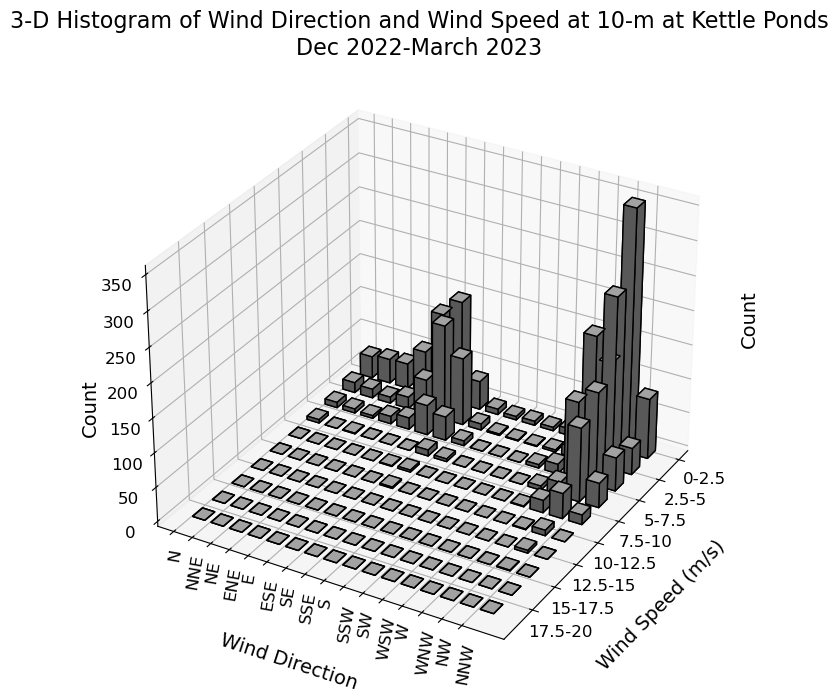

In [76]:
# create a 3d histogram in matplotlib to show the relationship between wind speed, wind direction, and total sublimation
# To generate some test data
xAmplitudes = df_to_use[f'wind_speed']
yAmplitudes = df_to_use[f'wind_direction']
# Create figure of wind speed and direction 3D histogram
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(xAmplitudes, yAmplitudes, bins=[10,16], range=[[0, 20], [0, 360]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1]+6.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = 1*np.ones_like(zpos)
dy = 15 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max', color='lightgrey', ec='black')
# rotate the plot
ax.view_init(30, 30,0)
# replace y-axis labels with cardinal wind direction lables
ax.set_yticks([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
ax.set_yticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], rotation=80, fontsize=12, ha='left')

ax.set_xticks([0,2.5,5,7.5,10,12.5,15,17.5])
ax.set_xticklabels(['0-2.5', '2.5-5', '5-7.5', '7.5-10', '10-12.5', '12.5-15', '15-17.5', '17.5-20'], rotation=0, fontsize=12, ha='center', va='bottom')
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=0)
# increase tick label size on zaxis
ax.tick_params(axis='z', labelsize=12)
# ax.set_zlim(0,40)
# show z-axis on the right
ax.zaxis.set_rotate_label(False)
ax.zaxis.set_label_position('both')

ax.set_zlabel('Count', rotation=90, fontsize=14)
ax.set_xlabel('Wind Speed (m/s)', fontsize=14)
ax.set_ylabel('Wind Direction', fontsize=14)
# pad the x-axis label
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.set_title('3-D Histogram of Wind Direction and Wind Speed at 10-m at Kettle Ponds\nDec 2022-March 2023', fontsize=16)

plt.show()

# Figure of Hourly Sublimation Rate Frequencies

In [92]:
# add rolling precipitation 
df_to_use['rolling_24H_precip'] = df_to_use['precipitation'].rolling(window=24).sum()
stormy_sublimation = df_to_use[(df_to_use['rolling_24H_precip']>=1) & (df_to_use['wind_speed']>=3)]
stormy_calm_sublimation = df_to_use[(df_to_use['rolling_24H_precip']>=1) & (df_to_use['wind_speed']<3)]
dry_windy_sublimation = df_to_use[(df_to_use['rolling_24H_precip']<1) & (df_to_use['wind_speed']>=3)]
dry_calm_sublimation = df_to_use[(df_to_use['rolling_24H_precip']<1) & (df_to_use['wind_speed']<3)]

In [93]:
# total sublimation in a time interval is the sublimation rate multiplied by the frequency of that rate
# cut each sublimation rate into 0.01 g/m^2/s bins
bins = np.arange(-0.10, 0.2, 0.01)
bins[10] = 0
def cut_bins(df, bins):
    df['binned'] = pd.cut(df['sublimation'], bins)
    return df
stormy_sublimation_freq = cut_bins(stormy_sublimation, bins).value_counts('binned').sort_index() * bins[1:]
stormy_calm_sublimation_freq = cut_bins(stormy_calm_sublimation, bins).value_counts('binned').sort_index() * bins[1:]
dry_windy_sublimation_freq = cut_bins(dry_windy_sublimation, bins).value_counts('binned').sort_index() * bins[1:]
dry_calm_sublimation_freq = cut_bins(dry_calm_sublimation, bins).value_counts('binned').sort_index() * bins[1:]

(-0.5, 5.0)

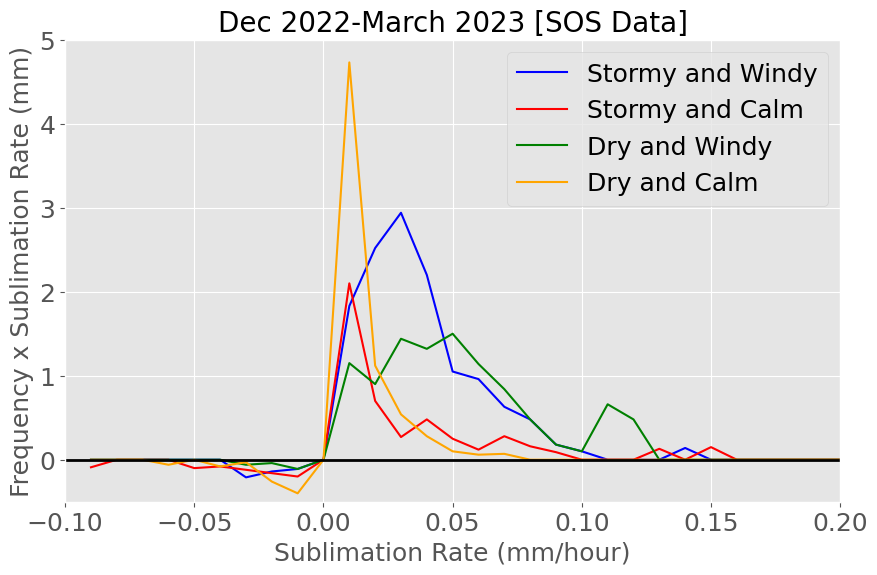

In [94]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bins[1:], stormy_sublimation_freq.values, label='Stormy and Windy', color='blue')
ax.plot(bins[1:], stormy_calm_sublimation_freq.values, label='Stormy and Calm', color='red')
ax.plot(bins[1:], dry_windy_sublimation_freq.values, label='Dry and Windy', color='green')
ax.plot(bins[1:], dry_calm_sublimation_freq.values, label='Dry and Calm', color='orange')
ax.legend(fontsize=18)
ax.axhline(0, color='black', lw=2)
ax.set_xlabel('Sublimation Rate (mm/hour)', size=18)
ax.set_ylabel('Frequency x Sublimation Rate (mm)', size=18)
# increase tick label size on x and y axes
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title('Dec 2022-March 2023 [SOS Data]', size=20)
ax.set_xlim(-0.1,0.2)
ax.set_ylim(-0.5,5)


# Make Heatmaps of Sublimation with Wind Speed and Direction

In [95]:
df_test['month'] = df_test.index.month
df_test['month'] = df_test['month'].where(df_test['month']!=12, 0)

In [100]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]


# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[f'wind_speed'], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[f'wind_direction'], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'


# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values
# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped_winds = df_test[['wsp_assignment', 'wdir_assignment', f'sublimation', 'precipitation','bsf']].groupby(['wsp_assignment', 'wdir_assignment']).sum()[f'sublimation']
grouped_months = df_test[['month', 'wdir_assignment', f'sublimation','precipitation','bsf']].groupby(['month', 'wdir_assignment']).sum()[f'sublimation']
# unstack and put into a dataframe
grouped_winds =(grouped_winds.unstack())
grouped_months =(grouped_months.unstack())

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [101]:
# plot grouped_winds as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped_winds.values, 
                         x=grouped_winds.columns, 
                         y=grouped_winds.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10,], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10+'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [102]:
# plotly radar plot using wind direction and percent of total precipitation
df_test['bsf_binary'] = df_test['bsf'].where(df_test['bsf']==0, 1)
df_no_bs = df_test[df_test['bsf_binary']==0][['bsf_binary','wind_direction']]
df_bs = df_test[df_test['bsf_binary']==1][['bsf_binary','wind_direction']]

# bins for wind direction
wdir_bins = np.arange(0, 361, 10)
# 
grouped_df_bs_count = (df_bs.groupby(pd.cut(df_bs['wind_direction'], bins=wdir_bins)).count())
percent_bs_obs = 100*(grouped_df_bs_count['bsf_binary']/grouped_df_bs_count['bsf_binary'].sum(axis=0))

grouped_df_no_bs_count = (df_no_bs.groupby(pd.cut(df_no_bs['wind_direction'], bins=wdir_bins)).count())
percent_no_bs_obs = 100*(grouped_df_no_bs_count['bsf_binary']/grouped_df_no_bs_count['bsf_binary'].sum(axis=0))

grouped_df_all_obs = (df_test['wind_direction'].groupby(pd.cut(df_test['wind_direction'], bins=wdir_bins)).count())
percent_all_obs = 100*(grouped_df_all_obs/grouped_df_all_obs.sum(axis=0))

for df in [percent_bs_obs, percent_no_bs_obs, percent_all_obs]:
    df.index = wdir_bins[:-1]


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [103]:
fig = go.Figure()

# Normalized Figure
fig.add_trace(go.Barpolar(
    name='Percent of blowing snow observations',
    r= percent_bs_obs.values.flatten(),
    theta= percent_bs_obs.index,
)
)

# Non-blowing snow Figure
fig.add_trace(go.Barpolar(
    base=0,
    name='Percent of non-blowing snow observations',
    r= percent_no_bs_obs.values.flatten(),
    theta= percent_no_bs_obs.index,
    opacity=0.5,
)
)

# fig.add_trace(go.Barpolar(
#     base=0,
#     name='Percent of all wind observations',
#     r= percent_all_obs.values.flatten(),
#     theta= percent_all_obs.index,
#     opacity=0.5,
#     # 
# ),
# )

fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=1,
    y=1

)
fig.update_layout(
    showlegend=True,
    barmode='overlay',
    polar=dict(
        bgcolor = "white",
        radialaxis_tickfont_size=12,
        radialaxis_range = [0, 20.5],
        radialaxis_tickvals=[5,10,15,20],
        radialaxis_ticktext=[str(f)+'%' for f in [5,10,15,20]],
        radialaxis_angle=-135,
        radialaxis_tickangle=-135,
        radialaxis = dict(
                        showline = False,
                        linewidth = 1,
                        gridcolor = "black",
                        gridwidth = 1,
                        tickfont=dict(size=14, color='black'),
                         ),
        angularaxis=dict(
            gridcolor='gray',
            tickmode='array',
            tickvals=[0,45,90,135,180,225,270,315],
            tickfont=dict(size=14),
            rotation=90,
            direction='clockwise'
        )),
        paper_bgcolor ='white',
        width=800,
        height=600,
        title=f'SOS 2023 - Wind Direction during Blowing and Non-Blowing Snow Conditions')



In [104]:
# plotly radar plot using wind direction and percent of total precipitation
df = df_to_use[df_to_use['wind_speed']>2][['precipitation','wind_direction','sublimation']]

# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wind_direction'], bins=np.arange(0, 361, 10))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wind_direction'], bins=np.arange(0, 361, 10))).count()['wind_direction']
# replace indeces where grouped_df_sum/grouped_df_count is > 1 with 0 for each beacuse it is likely an error
grouped_df_sum = grouped_df_sum.where(grouped_df_sum['precipitation'] / grouped_df_count <1, 0)
grouped_df_count = grouped_df_count.where(grouped_df_sum['precipitation'] / grouped_df_count < 1, 0)

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = (grouped_df_sum['precipitation'] / grouped_df_count).fillna(0)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = np.arange(0, 351, 10)
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]
# normalize to between 0 and 1
grouped_df_percent_norm = 100*(grouped_df_percent_norm / grouped_df_percent_norm.sum())

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm_sublimation = (grouped_df_sum['sublimation'] / grouped_df_count).fillna(0)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm_sublimation.index = np.arange(0, 351, 10)
# add the first value again
grouped_df_percent_norm_sublimation.loc[360] = grouped_df_percent_norm_sublimation.loc[0]
grouped_df_percent_norm_sublimation = 100*(grouped_df_percent_norm_sublimation / grouped_df_percent_norm_sublimation.sum())

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent = (grouped_df_sum['precipitation']).fillna(0)
# change out the index to be the cardinal wind directions
grouped_df_percent.index = np.arange(0, 351, 10)
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0]
# normalize to between 0 and 1
grouped_df_percent = 100*(grouped_df_percent / grouped_df_percent.sum())

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_sublimation = (grouped_df_sum['sublimation']).fillna(0)
# change out the index to be the cardinal wind directions
grouped_df_percent_sublimation.index = np.arange(0, 351, 10)
# add the first value again
grouped_df_percent_sublimation.loc[360] = grouped_df_percent_sublimation.loc[0]
grouped_df_percent_sublimation = 100*(grouped_df_percent_sublimation / grouped_df_percent_sublimation.sum())

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [105]:
fig = make_subplots(rows=1,cols=2,
                    specs=[[{'type': 'polar'}]*2], 
                    subplot_titles=['Normalized','Absolute'], 
                    column_widths=[0.45,0.45],
                    row_heights=[0.9])


# Normalized Figure
fig.add_trace(go.Scatterpolar(
    name='Precipiation Rate Normalized<br>by Wind Direction',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
    line_color='blue',
),1,1
)

fig.add_trace(go.Scatterpolar(
    name='Sublimation Rate Normalized<br>by Wind Direction',
    r= grouped_df_percent_norm_sublimation.values.flatten(),
    theta= grouped_df_percent_norm_sublimation.index,
    fill='toself',
    line_color='red',
),
1,1
)

# Absolute Figure
fig.add_trace(go.Scatterpolar(
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
    line_color='blue',
    showlegend=False,
),
1,2, 
)

fig.add_trace(go.Scatterpolar(
    r= grouped_df_percent_sublimation.values.flatten(),
    theta= grouped_df_percent_sublimation.index,
    fill='toself',
    line_color='red',
    showlegend=False,
), 
1,2
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.5,
    y=-0.2

)
fig.update_layout(
    showlegend=True,
    polar1=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 15],
        radialaxis_tickvals=[5,10,15],
        radialaxis_ticktext=['5%', '10%', '15%'],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
    polar2=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 15],
        radialaxis_tickvals=[5,10,15],
        radialaxis_ticktext=['5%', '10%', '15%'],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=800,
        height=500,
        title=f'SOS 2023 Winter Precipitation<br>by Wind Direction')



In [106]:
# plot grouped_months as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped_months.values, 
                         x=grouped_months.columns, 
                         y=grouped_months.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Month',
                  title=f'Sublimation by Month and Wind Direction',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[3,2,1,0], ticktext=['Mar', 'Feb', 'Jan', 'Dec'], range=([3.5,-0.5]))
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [107]:
fig = go.Figure()


fig.add_trace(go.Scatterpolar(
    name='December',
    r= grouped_months.loc[0].values,
    theta= grouped_months.columns,
)
)

fig.add_trace(go.Scatterpolar(
    name='January',
    r= grouped_months.loc[1].values,
    theta= grouped_months.columns,
)
)

fig.add_trace(go.Scatterpolar(
    name='February',
    r= grouped_months.loc[2].values,
    theta= grouped_months.columns,
)
)

fig.add_trace(go.Scatterpolar(
    name='March',
    r= grouped_months.loc[3].values,
    theta= grouped_months.columns,
)
)


fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        # radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SAIL 2023 Winter Precipitation by Wind Direction')


In [108]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[f'wind_speed'], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[f'wind_direction'], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped_temperature = df_test[['wsp_assignment', 'wdir_assignment',f'temperature']].groupby(['wsp_assignment', 'wdir_assignment']).mean()[f'temperature']
# unstack and put into a dataframe
grouped_temperature = grouped_temperature.unstack()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [109]:
# plot grouped_temperature as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped_temperature.values, 
                         x=grouped_temperature.columns, 
                         y=grouped_temperature.index,

                        colorbar={'title':'Temperature<br>(&deg;C)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-12,
                        zmax=0,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Temperature<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10,], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10+',])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [114]:

# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig1 = px.scatter(df_to_use.dropna(), 
                 x=f'wind_speed', 
                 y=f'sublimation', 
                 size='bsf', 
                 # color by wind direction
                 color=f'temperature',
                 color_continuous_scale='RdBu_r',
                 # make edge color black
                 # provide size scale
                    size_max=50,
                 title=f'Wind Speed and Sublimation Rate <br> sized by BSF and averaged over {timestep}H')


fig1.update_traces(marker=dict(
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                    text = df_to_use.dropna().index,
                    hovertemplate='Date: %{text} &deg;<br>Wind Speed: %{x} m/s<br>Sublimation Rate: %{y} mm/hr<br>Temperature: %{marker.color:.2f} &deg;C',
                  selector=dict(mode='markers'))

df_l = df_to_use.sort_values('bsf')
# fill df_1 with 0 for nan values
df_l = df_l.fillna(0)

fig2 = px.scatter(
    df_l,
    x=np.zeros(5),
    y=np.array(pd.cut(df_l["bsf"], bins=np.array([0,0.01,0.1,1,10,100]), right=False).unique().astype(str)),
    size=np.array([0.01,0.1,1,10,100]),
    size_max=50,
    # set color to gray
)

fig2.update_traces(marker=dict(
                            color='gray',
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))



fig = go.Figure(
    data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
    layout=fig1.layout,
)

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)'),
    yaxis1=dict(title='Sublimation Rate (mm/hr)'),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Blowing Snow Flux (g/m^2/s)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
    coloraxis_colorbar_title_text ='Temperature (&deg;C)'
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=-0.10, 
                                          xanchor="left", 
                                          title='Temperature (&deg;C)',
                                          orientation='h'))


In [115]:
# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig1 = px.scatter(df_to_use.dropna(), 
                 x=f'wind_speed', 
                 y=f'sublimation', 
                 size='bsf', 
                 # color by wind direction
                 color=f'wind_direction',
                 color_continuous_scale='twilight',
                 # make edge color black
                 # provide size scale
                    size_max=50,
                 title=f'Wind Speed and Sublimation Rate <br> sized by BSF and averaged over {timestep}H')


fig1.update_traces(marker=dict(
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                    text = df_to_use.dropna().index,
                    hovertemplate='Date: %{text} &deg;<br>Wind Speed: %{x} m/s<br>Sublimation Rate: %{y} mm/hr<br>Temperature: %{marker.color:.2f} &deg;C',
                  selector=dict(mode='markers'))

df_l = df_to_use.sort_values('bsf')
# fill df_1 with 0 for nan values
df_l = df_l.fillna(0)

fig2 = px.scatter(
    df_l,
    x=np.zeros(5),
    y=np.array(pd.cut(df_l["bsf"], bins=np.array([0,0.01,0.1,1,10,100]), right=False).unique().astype(str)),
    size=np.array([0.01,0.1,1,10,100]),
    size_max=50,
    # set color to gray
)

fig2.update_traces(marker=dict(
                            color='gray',
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))



fig = go.Figure(
    data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
    layout=fig1.layout,
)

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)'),
    yaxis1=dict(title='Sublimation Rate (mm/hr)'),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Blowing Snow Flux (g/m^2/s)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=0, 
                                          xanchor="left", 
                                          title='Wind Direction (&deg;)',
                                          orientation='h'))



In [116]:
# pull in the precipitation data from kettle ponds
precip_ds = xr.open_dataset('../../01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w23.nc')['binary_Amount']
# resample to 
precip_ds = precip_ds.resample(time='1D').sum()

In [121]:
ds = sos_1D_h2o_flux_ds
timestep=24
filtered_sublimation_1D = create_sublimation_timeseries_df(ds.sel(time=slice('2022-12-01', '2023-03-31')), timestep)#.loc[precip_ds.where(precip_ds>0, drop=True).time]
down_valley_filter_sublimation_1D = filtered_sublimation_1D[filtered_sublimation_1D['wind_direction']>225]
up_valley_filter_sublimation_1D = filtered_sublimation_1D[filtered_sublimation_1D['wind_direction']<225]

In [123]:
bsf_daily = np.log10(filtered_sublimation_1D['bsf'])
# remplace infinity with nan
bsf_daily = bsf_daily.replace([np.inf, -np.inf], np.nan)
# size between 0 and 100
bsf_daily = 100*(bsf_daily - bsf_daily.min())/(bsf_daily.max()-bsf_daily.min())
# fill na with 0
bsf_daily = bsf_daily.fillna(1)

bsf_daily_downvalley = bsf_daily.loc[down_valley_filter_sublimation_1D.index]
bsf_daily_upvalley = bsf_daily.loc[up_valley_filter_sublimation_1D.index]

divide by zero encountered in log10


In [124]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Optimal parameters: a = 0.022267239318625436, b = 1.6810043235862486
RMSE: 0.11426923336041762
MAE: 0.0816100310943698
R^2: 0.7194999127981208
Optimal parameters: a = 0.03753239672532824, b = 1.7265155271854566
RMSE: 0.23413574927144984
MAE: 0.17185936909395225
R^2: 0.36100889084199594


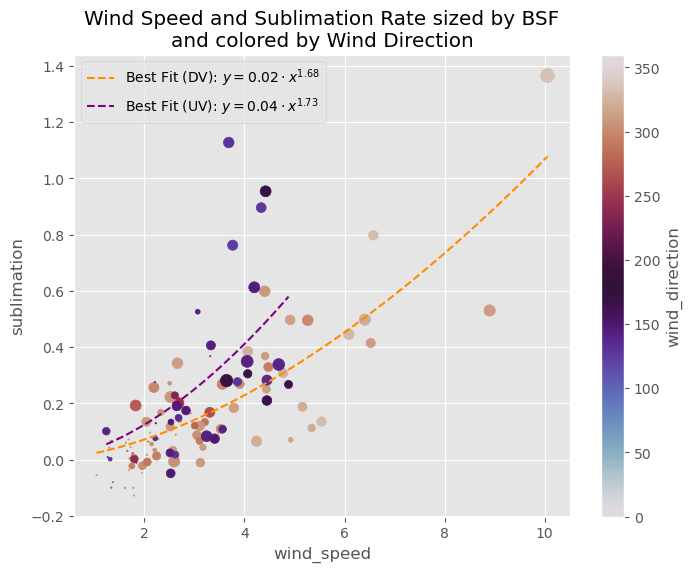

In [125]:
fig, ax = plt.subplots(figsize=(8,6))
# down valley plot
down_valley_filter_sublimation_1D.plot.scatter(x='wind_speed', 
                                              y='sublimation', 
                                              c='wind_direction', 
                                              colormap='twilight', 
                                              s=bsf_daily_downvalley, 
                                              vmin=0, vmax=360, 
                                              title='Wind Speed and Sublimation Rate sized by BSF\nand colored by Wind Direction',
                                              ax=ax)
def power_law_func(x, a, b):
    return a * np.power(x, b)

x = down_valley_filter_sublimation_1D['wind_speed'].values
y = down_valley_filter_sublimation_1D['sublimation'].values
# Fit the power law function to the absolute values of the data
popt, pcov = curve_fit(power_law_func, x, np.abs(y))

# Get the optimal parameters
a, b = popt

# Generate the best fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law_func(x_fit, a, b,)

# Reapply the sign of the original y values to the fitted values
y_fit_with_sign = np.sign(y) * power_law_func(x, a, b)

# Plot the data and the best fit line
ax.plot(x_fit, y_fit, color='darkorange',ls='--', label='Best Fit (DV): $y = {:.2f} \cdot x^{{{:.2f}}}$'.format(a, b))
# Calculate RMSE, MAE, and R^2
rmse = np.sqrt(mean_squared_error(y, y_fit_with_sign))
mae = mean_absolute_error(y, y_fit_with_sign)
r2 = r2_score(y, y_fit_with_sign)
# Print the parameters and error metrics
print(f'Optimal parameters: a = {a}, b = {b}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

# up valley plot
up_valley_filter_sublimation_1D.plot.scatter(x='wind_speed', 
                                            y='sublimation', 
                                            c='wind_direction', 
                                            colormap='twilight', 
                                            s=bsf_daily_upvalley, 
                                            vmin=0, vmax=360, 
                                            title='Wind Speed and Sublimation Rate sized by BSF\nand colored by Wind Direction',
                                            colorbar=False,
                                            ax=ax)
# plot a best fit line (log) for the up valley
# Define the logarithmic function
# Define the power law function

x = up_valley_filter_sublimation_1D['wind_speed'].values
y = up_valley_filter_sublimation_1D['sublimation'].values
# Fit the power law function to the absolute values of the data
popt, pcov = curve_fit(power_law_func, x, np.abs(y), p0=[1,2])

# Get the optimal parameters
a, b = popt

# Reapply the sign of the original y values to the fitted values
y_fit_with_sign = np.sign(y) * power_law_func(x, a, b)
# Generate the best fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law_func(x_fit, a, b)
# Plot the data and the best fit line
ax.plot(x_fit, y_fit, color='purple',ls='--', label='Best Fit (UV): $y = {:.2f} \cdot x^{{{:.2f}}}$'.format(a, b))
# Calculate RMSE, MAE, and R^2
rmse = np.sqrt(mean_squared_error(y, y_fit_with_sign))
mae = mean_absolute_error(y, y_fit_with_sign)
r2 = r2_score(y, y_fit_with_sign)
# Print the parameters and error metrics
print(f'Optimal parameters: a = {a}, b = {b}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')


ax.legend()

Optimal parameters: a = 0.017497596308574066, b = 1.6596688846054592
RMSE: 0.13350510863850193
MAE: 0.09528465383301889
R^2: 0.6171134222279586
Optimal parameters: a = 0.012875059632710668, b = 2.326091587196638
RMSE: 0.24856670732009425
MAE: 0.16307624409173682
R^2: 0.279813003981197


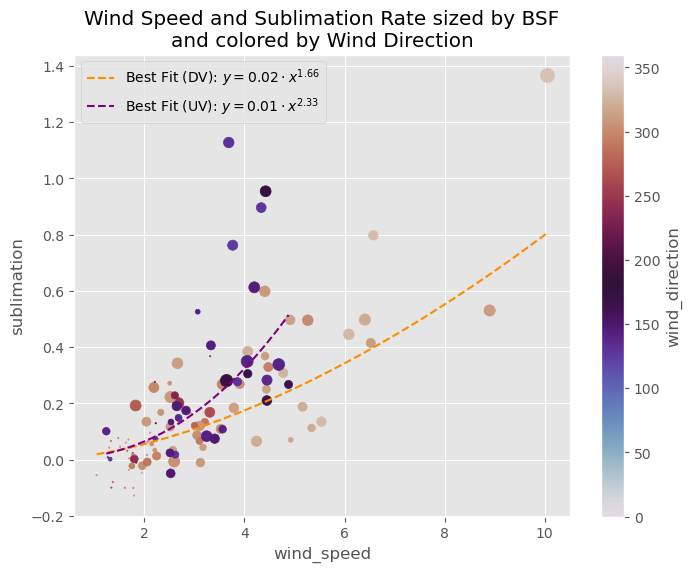

In [126]:
fig, ax = plt.subplots(figsize=(8,6))
# down valley plot
down_valley_filter_sublimation_1D.plot.scatter(x='wind_speed', 
                                              y='sublimation', 
                                              c='wind_direction', 
                                              colormap='twilight', 
                                              s=bsf_daily_downvalley, 
                                              vmin=0, vmax=360, 
                                              title='Wind Speed and Sublimation Rate sized by BSF\nand colored by Wind Direction',
                                              ax=ax)
def power_law_func(x, a, b):
    return a * np.power(x, b)

x = down_valley_filter_sublimation_1D['wind_speed'].values
y = down_valley_filter_sublimation_1D['sublimation'].values
# Transform the data using logarithms
log_x = np.log(x)
log_y = np.log(np.abs(y))

# Fit the linear model to the transformed data
popt, pcov = curve_fit(lambda t,a,b: a + b*t, log_x, log_y)

# Get the optimal parameters
log_a, b = popt
a = np.exp(log_a)

# Generate the best fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law_func(x_fit, a, b)

# Calculate the predicted log_y for the original x values
log_y_fit = log_a + b * log_x

# Calculate residuals
residuals = np.exp(log_y) - np.exp(log_y_fit)

# Calculate RMSE, MAE, and R^2 on the original data
rmse = np.sqrt(mean_squared_error(y, np.exp(log_y_fit)))
mae = mean_absolute_error(y, np.exp(log_y_fit))
r2 = r2_score(y, np.exp(log_y_fit))
# Print the parameters and error metrics
print(f'Optimal parameters: a = {a}, b = {b}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')
# Plot the data and the best fit line
ax.plot(x_fit, y_fit, color='darkorange',ls='--', label='Best Fit (DV): $y = {:.2f} \cdot x^{{{:.2f}}}$'.format(a, b))


# up valley plot
up_valley_filter_sublimation_1D.plot.scatter(x='wind_speed', 
                                            y='sublimation', 
                                            c='wind_direction', 
                                            colormap='twilight', 
                                            s=bsf_daily_upvalley, 
                                            vmin=0, vmax=360, 
                                            title='Wind Speed and Sublimation Rate sized by BSF\nand colored by Wind Direction',
                                            colorbar=False,
                                            ax=ax)
# plot a best fit line (log) for the up valley
# Define the logarithmic function
# Define the power law function

x = up_valley_filter_sublimation_1D['wind_speed'].values
y = up_valley_filter_sublimation_1D['sublimation'].values
# Define the power law function
def power_law_func(x, a, b):
    return a * np.power(x, b)

# Transform the data using logarithms
log_x = np.log(x)
log_y = np.log(np.abs(y))

# Fit the linear model to the transformed data
popt, pcov = curve_fit(lambda t,a,b: a + b*t, log_x, log_y)

# Get the optimal parameters
log_a, b = popt
a = np.exp(log_a)

# Generate the best fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law_func(x_fit, a, b)

# Calculate the predicted log_y for the original x values
log_y_fit = log_a + b * log_x

# Calculate residuals
residuals = np.exp(log_y) - np.exp(log_y_fit)

# Calculate RMSE, MAE, and R^2 on the original data
rmse = np.sqrt(mean_squared_error(y, np.exp(log_y_fit)))
mae = mean_absolute_error(y, np.exp(log_y_fit))
r2 = r2_score(y, np.exp(log_y_fit))
# Print the parameters and error metrics
print(f'Optimal parameters: a = {a}, b = {b}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')
# Generate the best fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law_func(x_fit, a, b)
# Plot the data and the best fit line
ax.plot(x_fit, y_fit, color='purple',ls='--', label='Best Fit (UV): $y = {:.2f} \cdot x^{{{:.2f}}}$'.format(a, b))

ax.legend()